<a href="https://colab.research.google.com/github/fabiobento/dnn-course-2024-1/blob/main/00_course_folder/cert_prof_time_series/class_02/TS%20-%20W2%20-%2008%20-%20Rede%20neural%20de%20camada%20%C3%BAnica%20(Laborat%C3%B3rio%202).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

adaptado de [Certificado Profissional Desenvolvedor do TensorFlow](https://www.coursera.org/professional-certificates/tensorflow-in-practice) de [Laurence Moroney](https://laurencemoroney.com/)

# Treinamento de uma rede neural de camada única com dados de séries temporais

Agora que você já viu os métodos estatísticos na semana anterior, passará a usar as redes neurais para criar seus modelos de previsão.

Você começará com uma rede simples neste notebook e nos próximos passará para arquiteturas mais complexas.

Ao final deste laboratório, você será capaz de:

* criar uma rede de camada única e treiná-la usando os mesmos dados sintéticos que você usou no laboratório anterior
* preparar dados de séries temporais para treinamento e avaliação
* medir o desempenho do seu modelo em relação a um conjunto de validação

## Importações

Primeiro, você importará os pacotes de que precisará para executar todo o código deste laboratório. Você usará:
* [Tensorflow](https://www.tensorflow.org/api_docs/python/tf) para criar seu modelo e preparar janelas de dados
* [Numpy](https://numpy.org/) para processamento numérico
* e a biblioteca [PyPlot](https://matplotlib.org/3.5.1/api/_as_gen/matplotlib.pyplot.html) do Matplotlib para visualização

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

2024-04-12 18:22:01.155549: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-12 18:22:01.178679: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-12 18:22:01.178703: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-12 18:22:01.178718: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-12 18:22:01.183110: I tensorflow/core/platform/cpu_feature_g

## Utilitários

Em seguida, você definirá algumas funções utilitárias que também viu nos laboratórios anteriores.

Elas se encarregarão da visualização dos dados da série temporal e as previsões do modelo, além de gerar os dados sintéticos.

In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    """
    Visualizar dados de séries temporais

    Args:
      time (vetor de int) - contém as etapas de tempo
      series (vetor de int) - contém as medidas para cada etapa de tempo
      format - estilo da linha ao plotar o gráfico
      label - rótulo para a linha
      start - primeiro passo de tempo a ser plotado
      end - última etapa de tempo a ser plotada
    """

    # Configuração das dimensões da figura do gráfico
    plt.figure(figsize=(10, 6))

    if type(series) is tuple:

      for series_num in series:
        # Plotar os dados da série temporal
        plt.plot(time[start:end], series_num[start:end], format)

    else:
      # Plotar os dados da série temporal
      plt.plot(time[start:end], series[start:end], format)

    # Rotular o eixo x
    plt.xlabel("Time")

    # Rotular o eixo y
    plt.ylabel("Value")

    # Sobrepor uma grade no gráfico
    plt.grid(True)

    # Desenhar o gráfico na tela
    plt.show()


def trend(time, slope=0):
    """
    Gera dados sintéticos que seguem uma linha reta com um valor de inclinação.

    Args:
      time (vetor de int) - contém as etapas de tempo
      slope (float) - determina a direção e a inclinação da linha

    Retorna:
      series (vetor de float) - medições que seguem uma linha reta
    """

    # Calcula a série linear dada a inclinação
    series = slope * time

    return series


def seasonal_pattern(season_time):
    """
    Apenas um padrão arbitrário, você pode alterá-lo se desejar

    Args:
      season_time (vetor de float) - contém as medições por etapa de tempo

    Retorna:
      data_pattern (vetor de float) - contém os valores de medição revisados de acordo com
                                      o padrão definido
    """

    # Gerar os valores usando um padrão arbitrário
    data_pattern = np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

    return data_pattern


def seasonality(time, period, amplitude=1, phase=0):
    """
    Repete o mesmo padrão em cada período

    Args:
      time (vetor de int) - contém as etapas de tempo
      period (int) - número de etapas de tempo antes da repetição do padrão
      amplitude (int) - valor de pico medido em um período
      phase (int) - número de etapas de tempo para deslocar os valores medidos

    Retorna:
      data_pattern (vetor de float) - dados sazonais dimensionados pela amplitude definida
    """

    # Definir os valores medidos por período
    season_time = ((time + phase) % period) / period

    # Gera os dados sazonais dimensionados pela amplitude definida
    data_pattern = amplitude * seasonal_pattern(season_time)

    return data_pattern


def noise(time, noise_level=1, seed=None):
    """Gera um sinal ruidoso normalmente distribuído

    Args:
      time (vetor de int) - contém as etapas de tempo
      noise_level (float) - fator de escala para o sinal gerado
      seed (int) - semente do gerador de números para repetibilidade

    Retorna:
      noise (vetor de float) - o sinal ruidoso
    """

    # Inicializar o gerador de números aleatórios
    rnd = np.random.RandomState(seed)

    # Gerar um número aleatório para cada etapa de tempo e dimensionar pelo nível de ruído
    noise = rnd.randn(len(time)) * noise_level

    return noise

## Gerar os dados sintéticos

O código abaixo gera os mesmos dados sintéticos que você usou no laboratório anterior.

Ele conterá 1.461 pontos de dados com:
* tendência,
* sazonalidade e
* ruído.

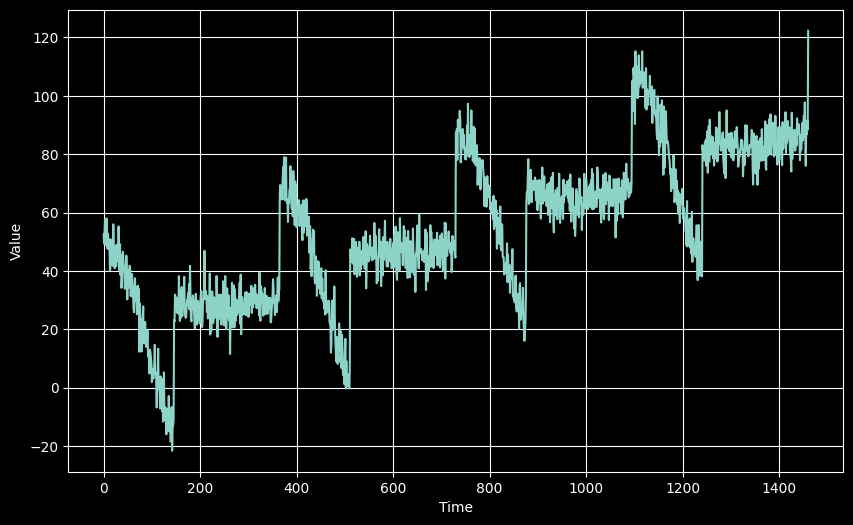

In [3]:
# Parâmetros
time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Criar a série
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

# Atualizar com ruído
series += noise(time, noise_level, seed=42)

# Plotar os resultados
plot_series(time, series)

## Dividir o conjunto de dados

Em seguida, você dividirá os dados acima em conjuntos de treinamento e validação. Você pegará os primeiros 1.000 pontos para treinamento, enquanto o restante será para validação,

In [4]:
# Definir o tempo de divisão
split_time = 1000

# Obter o conjunto de treino
time_train = time[:split_time]
x_train = series[:split_time]

# Obter o conjunto de validação
time_valid = time[split_time:]
x_valid = series[split_time:]

Você pode inspecionar esses conjuntos visualmente usando a mesma função de utilidade para plotagem.

Observe que, em geral, o conjunto de validação tem valores mais altos (ou seja, o eixo y) do que os do conjunto de treinamento.

Seu modelo deve ser capaz de prever esses valores apenas aprendendo com a tendência e a sazonalidade do conjunto de treinamento.

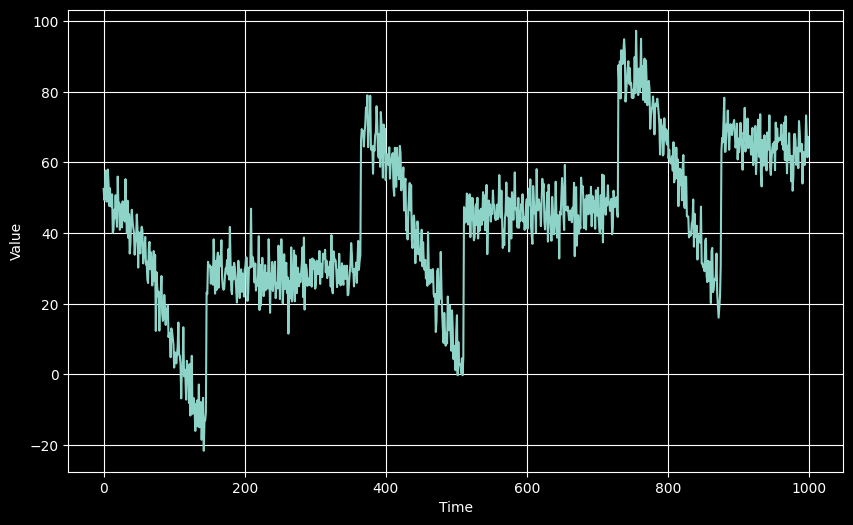

In [5]:
# Plotar o conjunto de treino
plot_series(time_train, x_train)

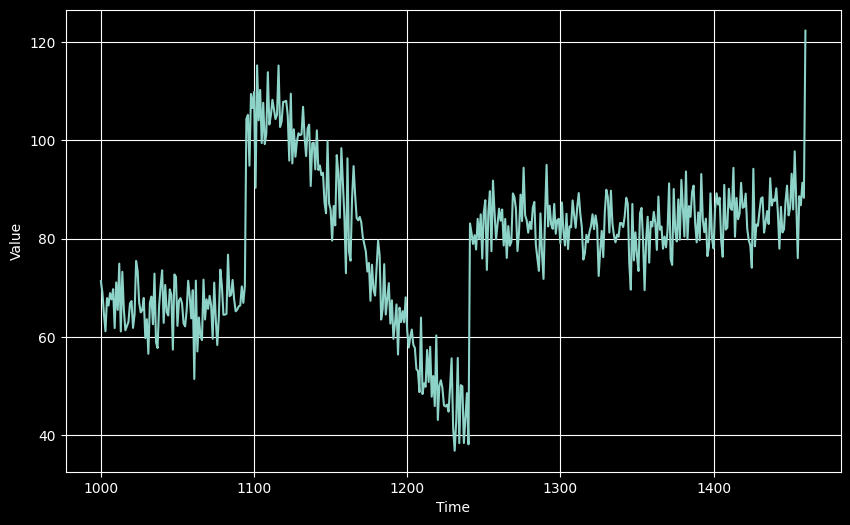

In [6]:
# Plotar o conjunto de validação
plot_series(time_valid, x_valid)

## Preparar recursos e rótulos

Em seguida, você preparará as janelas de dados conforme mostrado no laboratório anterior.

É bom declarar os parâmetros em uma célula separada para que você possa ajustá-los facilmente mais tarde, se desejar.

In [8]:
# Hiperparâmetros da série temporal
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

A função a seguir contém todas as etapas de pré-processamento que você realizou no laboratório anterior.
> Isso a torna modular para que você possa usá-la facilmente em seus outros projetos, se necessário.

Um aspecto a ser observado aqui é o `window_size + 1` quando você chama `dataset.window()`.
* Há um `+ 1` para indicar que você está usando o próximo ponto como rótulo.
* Por exemplo, os primeiros 20 pontos serão o recurso, portanto, o 21º ponto será o rótulo.

In [9]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """Gera janelas de conjunto de dados

    Args:
      series (vetor of float) - contém os valores da série temporal
      window_size (int) - o número de etapas de tempo a serem incluídas no recurso
      batch_size (int) - o tamanho do lote
      shuffle_buffer(int) - tamanho do buffer a ser usado para o método shuffle

    Retorna:
      dataset (TF Dataset) - Conjunto de dados TF contendo janelas de tempo
    """

    # Gerar um conjunto de dados TF a partir dos valores da série
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Janela de dados, mas só pega aqueles com o tamanho especificado
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)

    # Achatar as janelas, colocando seus elementos em um único lote
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Criar tuplas com recursos e rótulos
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Embaralhar as janelas
    dataset = dataset.shuffle(shuffle_buffer)

    # Criar lotes de janelas
    dataset = dataset.batch(batch_size).prefetch(1)

    return dataset

Agora você pode gerar as janelas do conjunto de dados a partir do conjunto de treinamento.

In [10]:
# Gerar as janelas do conjunto de dados
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

2024-04-12 18:46:06.837518: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-12 18:46:06.840640: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-12 18:46:06.840758: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Você pode inspecionar novamente a saída para ver se a função está se comportando conforme o esperado.

O código abaixo usará o método [`take()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#take) da API `tf.data.Dataset` para obter um único lote.
> Em seguida, ele imprimirá várias propriedades desse lote, como o tipo de dados e a forma dos elementos.

Como esperado, ele deve ter uma tupla de 2 elementos (ou seja, `(feature, label)`) e as formas desses elementos devem estar alinhadas com os tamanhos de lote e de janela que você declarou anteriormente, que são `32` e `20` por padrão, respectivamente.

In [11]:
# Imprimir propriedades de um único lote
for windows in dataset.take(1):
  print(f'tipo de dados: {type(windows)}')
  print(f'número de elementos na tupla: {len(windows)}')
  print(f'forma do primeiro elemento: {windows[0].shape}')
  print(f'forma do segundo elemento: {windows[1].shape}')

tipo de dados: <class 'tuple'>
número de elementos na tupla: 2
forma do primeiro elemento: (32, 20)
forma do segundo elemento: (32,)


## Criar e compilar o modelo

Em seguida, você criará a rede neural de camada única.

Será apenas uma camada [Dense](https://keras.io/api/layers/core_layers/dense/) de uma unidade, conforme mostrado abaixo.

Você atribuirá a camada a uma variável `l0` para que também possa ver os pesos finais posteriormente usando o método [`get_weights()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Layer#get_weights).

In [12]:
# Construir a rede neural de camada única
l0 = tf.keras.layers.Dense(1, input_shape=[window_size])
model = tf.keras.models.Sequential([l0])

# Imprimir os pesos da camada inicial
print("Pesos da camada: \n {} \n".format(l0.get_weights()))

# Imprimir o resumo do modelo
model.summary()

Pesos da camada: 
 [array([[-0.29031554],
       [-0.18366373],
       [ 0.2114464 ],
       [-0.31186742],
       [-0.4752473 ],
       [ 0.33700663],
       [-0.5298323 ],
       [-0.29138374],
       [ 0.34919935],
       [ 0.18703234],
       [-0.08513647],
       [-0.11605191],
       [ 0.3943864 ],
       [ 0.0346967 ],
       [ 0.39614612],
       [ 0.07554471],
       [ 0.49970526],
       [-0.26615265],
       [ 0.48968154],
       [ 0.03295994]], dtype=float32), array([0.], dtype=float32)] 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 21        
                                                                 
Total params: 21 (84.00 Byte)
Trainable params: 21 (84.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Você definirá [*mean squared error (mse)*](https://www.tensorflow.org/api_docs/python/tf/keras/losses/MeanSquaredError) como a função de perda e usará [*stochastic gradient descent (SGD)*](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/SGD) para otimizar os pesos durante o treinamento.

In [13]:
# Definir os parâmetros de treinamento
model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9))

## Treinar o modelo

Agora você pode prosseguir com o treinamento do modelo. Você alimentará as janelas de dados preparadas e executará o treinamento por 100 épocas.

In [14]:
# Treine o modelo
model.fit(dataset,epochs=100)

Epoch 1/100
31/31 [==============================] - 0s 1ms/step - loss: 291.5539
Epoch 2/100
31/31 [==============================] - 0s 1ms/step - loss: 139.0284
Epoch 3/100


2024-04-12 18:50:58.093352: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7741d804d100 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-12 18:50:58.093373: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 SUPER, Compute Capability 7.5
2024-04-12 18:50:58.098298: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8600
2024-04-12 18:50:58.131722: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2024-04-12 18:50:58.194552: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 7709129081643756538
2024-04-12 18:50:58.194596: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 3252293585020249979
2024-04-12 18:50:58.194618: I tensorflow/core/framework/

31/31 [==============================] - 0s 2ms/step - loss: 120.4259
Epoch 4/100
31/31 [==============================] - 0s 1ms/step - loss: 110.1758
Epoch 5/100
31/31 [==============================] - 0s 1ms/step - loss: 103.4047
Epoch 6/100
31/31 [==============================] - 0s 1ms/step - loss: 96.6275
Epoch 7/100
31/31 [==============================] - 0s 854us/step - loss: 93.5081
Epoch 8/100
31/31 [==============================] - 0s 909us/step - loss: 91.1086
Epoch 9/100
31/31 [==============================] - 0s 1ms/step - loss: 86.9772
Epoch 10/100
31/31 [==============================] - 0s 824us/step - loss: 85.4166
Epoch 11/100
31/31 [==============================] - 0s 859us/step - loss: 83.7061
Epoch 12/100
31/31 [==============================] - 0s 907us/step - loss: 80.1086
Epoch 13/100
31/31 [==============================] - 0s 949us/step - loss: 79.7655
Epoch 14/100
31/31 [==============================] - 0s 869us/step - loss: 76.6997
Epoch 15/100
31/31

Você pode ver os pesos finais chamando novamente o método `get_weights()`.

In [ ]:
# Print the layer weights
print("Layer weights {}".format(l0.get_weights()))

## Previsão do modelo

Com o treinamento concluído, agora você pode medir o desempenho do seu modelo.

Você pode gerar uma previsão de modelo passando um lote de janelas de dados.

Se você for cortar uma janela da matriz `series` original, precisará adicionar uma dimensão de lote antes de passá-la para o modelo.

Isso pode ser feito indexando com a constante [`np.newaxis`](https://numpy.org/doc/stable/reference/constants.html?highlight=newaxis#numpy.newaxis) ou usando o método [`np.expand_dims()`](https://numpy.org/doc/stable/reference/generated/numpy.expand_dims.html).

In [15]:
# Forma dos primeiros 20 pontos de dados slice
print(f'formato da série[0:20]: {series[0:20].shape}')

# Forma após adicionar uma dimensão de lote
print(f'formato da série[0:20][np.newaxis]: {series[0:20][np.newaxis].shape}')

# Forma após adicionar uma dimensão de lote (forma alternativa)
print(f'formato da série[0:20][np.newaxis]: {np.expand_dims(series[0:20], axis=0).shape}')

# Previsão de modelo de amostra
print(f'predição do modelo: {model.predict(series[0:20][np.newaxis])}')

formato da série[0:20]: (20,)
formato da série[0:20][np.newaxis]: (1, 20)
formato da série[0:20][np.newaxis]: (1, 20)
1/1 [==============================] - 0s 42ms/step
predição do modelo: [[43.159637]]


Para calcular as métricas, você deverá gerar previsões de modelos para seu conjunto de validação.
* Lembre-se de que esse conjunto se refere a pontos nos índices `1000` a `1460` de toda a série.
* Você precisará codificar as etapas para gerar essas previsões a partir do seu modelo. A célula abaixo demonstra uma maneira de fazer isso.

Basicamente, ela alimenta o modelo com toda a série, 20 pontos de cada vez, e anexa todos os resultados a uma lista `forecast`. Em seguida, ele cortará os pontos que correspondem ao conjunto de validação.

O índice de fatia abaixo é `split_time - window_size:` porque a lista de previsão é menor do que a série em 20 pontos (ou seja, o tamanho da janela).
* Como o tamanho da janela é 20, o primeiro ponto de dados na lista `forecast` corresponde à previsão de tempo no índice `20`.
* Você não pode fazer previsões nos índices `0` a `19` porque eles são menores que o tamanho da janela.
* Portanto, ao dividir com `split_time - window_size:`, você obterá os pontos nos índices de tempo que se alinham com os do conjunto de validação.

**Observação: você pode notar que essa célula demora um pouco para ser executada. Nos próximos dois laboratórios, você verá outras abordagens para gerar previsões e acelerar a execução do código. Talvez você já tenha algumas ideias e fique à vontade para testá-las depois de concluir este laboratório.**

In [16]:
# Inicializar uma lista
forecast = []

# Use o modelo para prever pontos de dados por tamanho de janela
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

# Corte os pontos que estão alinhados com o conjunto de validação
forecast = forecast[split_time - window_size:]

# Compare o número de elementos nas previsões e no conjunto de validação
print(f'comprimento da lista de previsão: {len(forecast)}')
print(f'forma do conjunto de validação: {x_valid.shape}')

1/1 [==============================] - 0s 11ms/step
comprimento da lista de previsão: 461
forma do conjunto de validação: (461,)


Para visualizar os resultados, você precisará converter as previsões em um formato aceito pela função do utilitário `plot_series()`.

Isso envolve a conversão da lista em uma matriz numérica e a eliminação dos eixos unidimensionais.

forma após a conversão para matriz numérica: (461, 1, 1)
formato após a compressão: (461,)


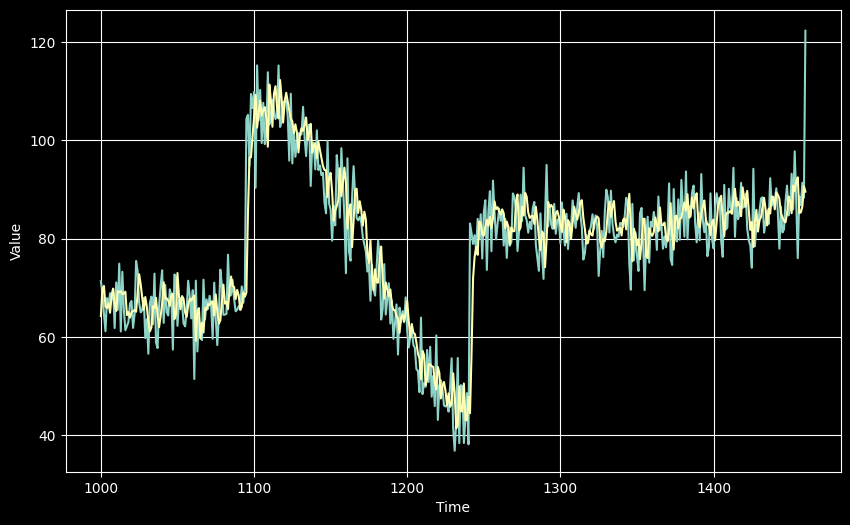

In [17]:
# Visualizar formas depois de usar os métodos de conversão e compressão
print(f'forma após a conversão para matriz numérica: {np.array(forecast).shape}')
print(f'formato após a compressão: {np.array(forecast).squeeze().shape}')

# Converta em uma matriz numérica e elimine os eixos de dimensão única
results = np.array(forecast).squeeze()

# Sobrepor os resultados com o conjunto de validação
plot_series(time_valid, (x_valid, results))

Você pode calcular as métricas chamando as mesmas funções de antes. Você obterá um MAE próximo a 5.

In [18]:
# Calcular as métricas
print(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

46.972794
5.156387


## Resumo

Neste laboratório, você conseguiu criar e treinar uma rede neural de camada única em dados de séries temporais:
* preparou janelas de dados
* alimentou o modelo e
* as previsões finais mostram resultados comparáveis com a análise estatística que você anteiormente.

Nos próximos laboratórios, você tentará adicionar mais camadas e também verá algumas otimizações que podem ser feitas ao treinar o modelo.